# Stacked Radial Thermodynamic Profile (CAMELS)

In [15]:
pip install yt

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pyxsim

Note: you may need to restart the kernel to use updated packages.


In [17]:
import yt
import pyxsim
from tqdm import tqdm

import h5py
import numpy as np
import pylab as plt

import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits

from soxs.utils import soxs_cfg
soxs_cfg.set("soxs", "bkgnd_nH", "0.018") # avoid configparser error by specifying here
import soxs
from concurrent.futures import ProcessPoolExecutor, as_completed

In [48]:
snap = "060"
r_norm_max = 15
r_norm_min = 1e-2
nbins = 10
ex = ["ex0", "ex1", "ex2", "ex3"]

#hm = ["1011", "1112", "1213"]
#tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]
#num = 3

In [49]:
def process_single_halo(haloID, label, num):
    try:
        f_snapshot = f'/home/jovyan/Data/Sims/IllustrisTNG/EX/EX_{num}/snapshot_{snap}.hdf5'
        f_catalog  = f'/home/jovyan/Data/FOF_Subfind/IllustrisTNG/EX/EX_{num}/groups_{snap}.hdf5'
        
        f = h5py.File(f_catalog, 'r')
        lentype_h = f['Group/GroupLenType'][:]
        r200_all = f['Group/Group_R_Crit200'][:]
        c_all = f['Group/GroupPos'][:]
        f.close()
                
        r2001 = r200_all[haloID]
        center = c_all[haloID]
        
        offset = np.sum(lentype_h[:haloID], axis=0)
        start = offset[0]
        end = offset[0] + lentype_h[haloID, 0]
        indices = np.arange(start, end)
        
        with h5py.File(f_snapshot, "r") as f_in:
            header_snap = dict(f_in['Header'].attrs)
            parttype0 = f_in["PartType0"]
            keys = list(parttype0.keys())

            filename = f"halo_{label}_{haloID}.hdf5"
            with h5py.File(filename, "w") as f_out:
                grp = f_out.create_group("PartType0")
                for key in keys:
                    data = parttype0[key][indices]
                    grp.create_dataset(key, data=data)

                header_grp = f_out.create_group('Header')
                header_grp.attrs['NumFilesPerSnapshot'] = 1
                header_grp.attrs['MassTable'] = header_snap['MassTable']
                header_grp.attrs['BoxSize'] = header_snap['BoxSize']
                header_grp.attrs['Time'] = header_snap['Time']
                header_grp.attrs['Redshift'] = header_snap['Redshift']
                gas_count = len(grp['Density'][:])
                header_grp.attrs['NumPart_ThisFile'] = np.array([gas_count,0,0,0,0,0])
                header_grp.attrs['HubbleParam'] = header_snap['HubbleParam']
                header_grp.attrs['Omega0'] = header_snap['Omega0']
                header_grp.attrs['OmegaLambda'] = header_snap['OmegaLambda']
                header_grp.attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
                header_grp.attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
                header_grp.attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        ds = yt.load(filename)

        c = ds.arr(center, "code_length").to("kpc")
        r200 = ds.arr(r2001, "code_length").to("kpc")

        sp = ds.sphere(c, r_norm_max * r200)
        radii = np.linalg.norm(sp["PartType0", "Coordinates"].to("kpc") - c, axis=1) / r200
        #r_bins = np.linspace(0, r_norm_max, nbins + 1)
        r_bins = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)

        def bin_profile(quantity):
            binned = np.array([
                np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
                if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
                for i in range(nbins)
            ])
            return np.nan_to_num(binned, nan=0.0)

        temp = bin_profile(sp["gas", "temperature"].to("K"))
        entropy = bin_profile(sp["gas", "entropy"].to("keV*cm**2"))
        pressure = bin_profile(sp["gas", "pressure"].to("dyne/cm**2"))
        density = bin_profile(sp["gas", "density"].to("g/cm**3"))

        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return temp, entropy, pressure, density

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return None

def combined_profiles(halo_list, label, hm, num):
    temp_all = []
    entropy_all = []
    pressure_all = []
    density_all = []

    with ProcessPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(process_single_halo, haloID, label, num): haloID for haloID in halo_list}
        with tqdm(total=len(futures), desc=f"Processing {label} halos") as pbar:
            for future in as_completed(futures):
                result = future.result()
                if result:
                    t, e, p, d = result
                    temp_all.append(t)
                    entropy_all.append(e)
                    pressure_all.append(p)
                    density_all.append(d)
                pbar.update(1)


    np.savez(f"combined_{hm}_{label}.npz",
             temperature_mean=np.nanmean(temp_all, axis=0),
             temperature_sem=np.nanstd(temp_all, axis=0, ddof=1) / np.sqrt(len(temp_all)),
             entropy_mean=np.nanmean(entropy_all, axis=0),
             entropy_sem=np.nanstd(entropy_all, axis=0, ddof=1) / np.sqrt(len(entropy_all)),
             pressure_mean=np.nanmean(pressure_all, axis=0),
             pressure_sem=np.nanstd(pressure_all, axis=0, ddof=1) / np.sqrt(len(pressure_all)),
             density_mean=np.nanmean(density_all, axis=0),
             density_sem=np.nanstd(density_all, axis=0, ddof=1) / np.sqrt(len(density_all)))

    print(f"✅ Saved combined_{hm}_{label}.npz")

In [50]:
hm2 = 1213
#hm3 =     3 
data2 = np.load("ex2_z0102.npz")
combined_profiles(data2[f"ex2_{hm2}"], ex[2],hm2, 2)
#combined_profiles(data2[f"ex2_{hm3}"], ex[2],hm3, 2)

data3 = np.load("ex3_z0102.npz")
combined_profiles(data3[f"ex3_{hm2}"], ex[3],hm2, 3)
#combined_profiles(data3[f"ex3_{hm3}"], ex[3],hm3,  3)           

data1 = np.load("ex1_z0102.npz")
combined_profiles(data1[f"ex1_{hm2}"], ex[1],hm2, 1)
#combined_profiles(data1[f"ex1_{hm3}"], ex[1],hm3,  1)

data0 = np.load("ex0_z0102.npz")
combined_profiles(data0[f"ex0_{hm2}"], ex[0],hm2, 0)
#combined_profiles(data0[f"ex0_{hm3}"], ex[0],hm3, 0)           

Processing ex2 halos:   0%|          | 0/11 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-20 02:54:58,205 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:54:58,583 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-20 02:54:58,585 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-20 02:54:58,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-20 02:54:58,589 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-20 02:54:58,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-20 02:54:58,591 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-20 02:54:58,592 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-20 02:54:58,593 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-05-20 02:54:58,594 Parameters: omega_radiation           = 0.0
yt : [INFO  

✅ Saved combined_1213_ex2.npz



Processing ex3 halos:   0%|          | 0/10 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-20 02:55:30,890 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:55:31,085 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:55:31,088 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:55:31,187 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-20 02:55:31,188 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-20 02:55:31,190 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-20 02:55:31,191 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-20 02:55:31,192 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-20 02:55:31,193 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-20 02:55:31,194 Parameters: omega_lambda       

✅ Saved combined_1213_ex3.npz



Processing ex1 halos:   0%|          | 0/8 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-20 02:55:57,285 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:55:57,331 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:55:57,486 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:55:57,678 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-20 02:55:57,680 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-20 02:55:57,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-20 02:55:57,683 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-20 02:55:57,684 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-20 02:55:57,685 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-20 02:55:57,686 Parameters: omega_lambda        

✅ Saved combined_1213_ex1.npz



Processing ex0 halos:   0%|          | 0/11 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-20 02:56:19,015 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:56:19,189 Calculating time from 4.884e-01 to be 1.833e+17 seconds
yt : [INFO     ] 2025-05-20 02:56:19,285 Parameters: current_time              = 1.832656005258152e+17 s
yt : [INFO     ] 2025-05-20 02:56:19,286 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-20 02:56:19,287 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-20 02:56:19,289 Parameters: domain_right_edge         = [25000. 25000. 25000.]
yt : [INFO     ] 2025-05-20 02:56:19,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-20 02:56:19,291 Parameters: current_redshift          = 1.0476023211521182
yt : [INFO     ] 2025-05-20 02:56:19,292 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-05-20 02:56:19,293 Parameters: omega_matter              = 0.3

✅ Saved combined_1213_ex0.npz


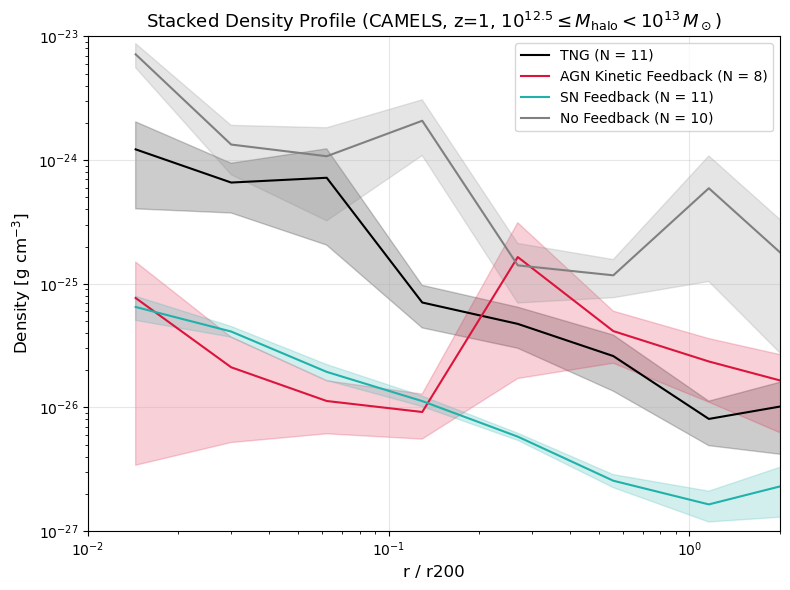

In [53]:
import numpy as np
import pylab as plt

#bin_edges = np.linspace(0, r_norm_max, nbins + 1)
#bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

bin_edges = np.logspace(np.log10(r_norm_min), np.log10(r_norm_max), nbins + 1)
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
#print(bin_centers)
data0 = np.load("ex0_z0102.npz")
data1 = np.load("ex1_z0102.npz")
data2 = np.load("ex2_z0102.npz")
data3 = np.load("ex3_z0102.npz")
'''
N0 = len(data0["ex0_3"])
N1 = len(data1["ex1_3"])
N2 = len(data2["ex2_3"])
N3 = len(data3["ex3_3"])

meaning = [
    f"TNG (N = {N0})",
    f"AGN Kinetic Feedback (N = {N1})",
    f"SN Feedback (N = {N2})",
    f"No Feedback (N = {N3})"]
'''
colors = ["black", "crimson", "lightseagreen", "grey"]
# Halo mass bins
hm_list = ["1213"]  # example bins like 10^12–10^12.5, 10^12.5–10^13
hmname = [r"$10^{{12.5}} \leq M_{{\mathrm{{halo}}}} < 10^{{13}} \, M_\odot$"]
          #r"$10^{{12.5}} \leq M_{{\mathrm{{halo}}}} < 10^{{13}} \, M_\odot$"]
          
# Thermodynamic quantities to plot
quantities = [
    #("temperature", "Temperature [K]"),
    ("density", "Density [g cm$^{-3}$]")]
    
for hm,hmn in zip(hm_list, hmname):
    N0 = len(data0[f"ex0_{hm}"])
    N1 = len(data1[f"ex1_{hm}"])
    N2 = len(data2[f"ex2_{hm}"])
    N3 = len(data3[f"ex3_{hm}"])

    meaning = [
    f"TNG (N = {N0})",
    f"AGN Kinetic Feedback (N = {N1})",
    f"SN Feedback (N = {N2})",
    f"No Feedback (N = {N3})"]
    for quantity, ylabel in quantities:
        plt.figure(figsize=(8, 6))

        for model, color, label_text in zip(ex, colors, meaning):
            fname = f"combined_{hm}_{model}.npz"
            data = np.load(fname)

            mean = data[f"{quantity}_mean"]
            sem = data[f"{quantity}_sem"]

            plt.plot(bin_centers, mean, label=label_text, color=color)
            plt.fill_between(bin_centers, mean - sem, mean + sem, alpha=0.2, color=color)

        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("r / r200", fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.title(f"Stacked {quantity.capitalize()} Profile (CAMELS, z=1, {hmn})", fontsize=13)
        plt.grid(alpha=0.3)
        plt.xlim(1e-2, 2)
        plt.ylim(1e-27, 1e-23)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f"{quantity}_profile_{hm}.png", dpi=300)
        plt.show()